In [1]:
!pip install catboost
!pip install nb_black

     |████████████████████████████████| 12.7MB 11.2MB/s eta 0:00:01
     |████████████████████████████████| 51kB 5.2MB/s eta 0:00:011
     |████████████████████████████████| 27.7MB 14.9MB/s eta 0:00:01    |█                               | 819kB 16.4MB/s eta 0:00:02


In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

import catboost as cb

wids_path = "/Users/diana/Documents/projects/widsdatathon2022"
sys.path.append(wids_path)

from global_vars import all_feature_columns, response_column
import utils.model_utils as mu
from utils.data_utils import *
from utils.visualize import *
from utils.data_process_utils import *

pd.set_option("display.max_columns", 500)
sns.set_context("talk")

#### read in data
test_df = pd.read_csv(f"{wids_path}/data/test.csv")
print(f"Test dimension: {test_df.shape}")
train_df = pd.read_csv(f"{wids_path}/data/train.csv")
print(f"Train dimension: {train_df.shape}")
sample_solution_df = pd.read_csv(f"{wids_path}/data/sample_solution.csv")
print(f"Sample solution dimension: {sample_solution_df.shape}")
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

Test dimension: (9705, 63)
Train dimension: (75757, 64)
Sample solution dimension: (9705, 2)


<IPython.core.display.Javascript object>

In [3]:
# Compare train vs test data coverage for diff categories
(
    train_df.groupby(["facility_type"])["id"].count() / train_df["id"].size * 100
).reset_index(name="train_pct").merge(
    (
        test_df.groupby(["facility_type"])["id"].count() / test_df["id"].size * 100
    ).reset_index(name="test_frac"),
    on="facility_type",
    how="outer",
).sort_values(
    "train_pct", ascending=False
)

,facility_type,train_pct,test_frac
27,Multifamily_Uncategorized,52.080996,22.658423
32,Office_Uncategorized,16.515966,19.773313
6,Education_Other_classroom,5.095239,9.170531
21,Lodging_Hotel,2.769381,3.781556
0,2to4_Unit_Building,2.498779,9.953632
2,Commercial_Other,2.302097,3.348789
1,5plus_Unit_Building,1.680373,7.058217
56,Warehouse_Nonrefrigerated,1.656613,1.133436
50,Retail_Uncategorized,1.491611,2.318393
5,Education_College_or_university,1.393931,2.081401


<IPython.core.display.Javascript object>

In [4]:
feature_dict = {
    "base_cat": {
        "cols_to_reduce": [],
        "log10_transform_cols": [],
        "if_one_hot": False,
        "backfill_dict": {},
    },
    "base_onehot": {
        "cols_to_reduce": [],
        "log10_transform_cols": [],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_onehot": {
        "cols_to_reduce": [],
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_temp_pca_onehot": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_temp_pca_onehot_impute": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {
            "energy_star_rating": ["state_factor", "building_class", "facility_type"]
        },
    },
    "log_temp_pca_cat": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": False,
        "backfill_dict": {},
    },
    "log_temp_precip_pca_onehot": {
        "cols_to_reduce": temp_col_list + inch_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
}

<IPython.core.display.Javascript object>

Fitting PCA with 9 components


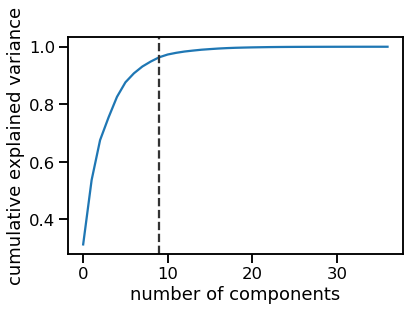

<IPython.core.display.Javascript object>

In [5]:
config_name = "log_temp_pca_onehot"
cols_to_reduce = feature_dict[config_name]["cols_to_reduce"]
log10_transform_cols = feature_dict[config_name]["log10_transform_cols"]
backfill_dict = feature_dict[config_name]["backfill_dict"]
if_scale = False
if_one_hot = feature_dict[config_name]["if_one_hot"]

train_filter_df, test_filter_df, pca_cols = process_data(
    train_df.drop_duplicates(),
    test_df.drop_duplicates(),
    cols_to_reduce,
    log10_transform_cols,
    0,
    backfill_dict,
)

In [6]:
train_filter_df.filter(like="energy_star_rating").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75757 entries, 0 to 75756
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   energy_star_rating  49048 non-null  float64
dtypes: float64(1)
memory usage: 1.2 MB


<IPython.core.display.Javascript object>

In [7]:
# Set feature columns after data transformations
features_columns = (
    list(set(all_feature_columns) - set(cols_to_reduce) - set(log10_transform_cols))
    + pca_cols
    + [f"log10_{col}" for col in log10_transform_cols]
)
if backfill_dict:
    backfill_cols = list(backfill_dict.keys())
    features_columns = list(set(features_columns) - set(backfill_cols)) + [
        f"backfilled_{col}" for col in backfill_cols
    ]
print(config_name, features_columns, if_one_hot)

log_temp_pca_onehot ['building_class', 'state_factor', 'snowdepth_inches', 'facility_type', 'year_built', 'days_below_20f', 'energy_star_rating', 'heating_degree_days', 'days_with_fog', 'snowfall_inches', 'direction_peak_wind_speed', 'days_below_30f', 'days_above_90f', 'days_above_100f', 'elevation', 'days_below_10f', 'days_below_0f', 'max_wind_speed', 'cooling_degree_days', 'days_above_80f', 'direction_max_wind_speed', 'precipitation_inches', 'days_above_110f', 'temp_pca1', 'temp_pca2', 'temp_pca3', 'temp_pca4', 'temp_pca5', 'temp_pca6', 'temp_pca7', 'temp_pca8', 'temp_pca9', 'log10_floor_area'] True


<IPython.core.display.Javascript object>

Running catboost
Modeling 1...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 2...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 3...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 4...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 5...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 6...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Average RMSE:
left_out_year     3.500000
train_rmse       35.608406
test_rmse        46.867058
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,35.034329,57.331150
1,2,34.958938,44.024230
2,3,34.224326,47.929794
3,4,35.703921,44.167458
4,5,37.122656,38.074153
5,6,36.606268,49.675565


Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Whole data train RMSE: 35.65573300854891


,left_out_year,train_rmse,test_rmse,method
0,1.0,35.034329,57.331150,loyo
1,2.0,34.958938,44.024230,loyo
2,3.0,34.224326,47.929794,loyo
3,4.0,35.703921,44.167458,loyo
4,5.0,37.122656,38.074153,loyo
5,6.0,36.606268,49.675565,loyo
6,0.0,35.655733,NaN,whole train


/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running catboost
Modeling 1...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 2...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 3...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 4...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 5...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 6...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Average RMSE:
left_out_year     3.50000
train_rmse       32.62016
test_rmse        45.92126
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,32.289087,55.925554
1,2,32.017183,42.358033
2,3,30.998897,47.068946
3,4,32.540526,42.338062
4,5,34.244795,39.371380
5,6,33.630473,48.465585


Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Whole data train RMSE: 32.69410674017231


,left_out_year,train_rmse,test_rmse,method
0,1.0,32.289087,55.925554,loyo
1,2.0,32.017183,42.358033,loyo
2,3.0,30.998897,47.068946,loyo
3,4.0,32.540526,42.338062,loyo
4,5.0,34.244795,39.371380,loyo
5,6.0,33.630473,48.465585,loyo
6,0.0,32.694107,NaN,whole train


/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running catboost
Modeling 1...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 2...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 3...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 4...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 5...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 6...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Average RMSE:
left_out_year     3.500000
train_rmse       29.724410
test_rmse        44.211118
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,29.570256,54.723238
1,2,29.064331,42.263801
2,3,27.956652,46.101251
3,4,29.783479,40.805236
4,5,31.198586,35.457697
5,6,30.773158,45.915484


Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Whole data train RMSE: 29.987523971696483


,left_out_year,train_rmse,test_rmse,method
0,1.0,29.570256,54.723238,loyo
1,2.0,29.064331,42.263801,loyo
2,3.0,27.956652,46.101251,loyo
3,4.0,29.783479,40.805236,loyo
4,5.0,31.198586,35.457697,loyo
5,6.0,30.773158,45.915484,loyo
6,0.0,29.987524,NaN,whole train


/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running catboost
Modeling 1...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 2...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 3...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 4...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 5...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Modeling 6...
Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Average RMSE:
left_out_year     3.500000
train_rmse       26.809504
test_rmse        44.197713
dtype: float64


,left_out_year,train_rmse,test_rmse
0,1,26.750888,54.539157
1,2,26.002646,42.266315
2,3,25.116141,45.976886
3,4,26.690624,40.736348
4,5,28.317530,36.616610
5,6,27.979192,45.050965


Columns to be dummied: ['building_class', 'facility_type', 'state_factor']
Whole data train RMSE: 27.141211917501913


,left_out_year,train_rmse,test_rmse,method
0,1.0,26.750888,54.539157,loyo
1,2.0,26.002646,42.266315,loyo
2,3.0,25.116141,45.976886,loyo
3,4.0,26.690624,40.736348,loyo
4,5.0,28.317530,36.616610,loyo
5,6.0,27.979192,45.050965,loyo
6,0.0,27.141212,NaN,whole train


/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


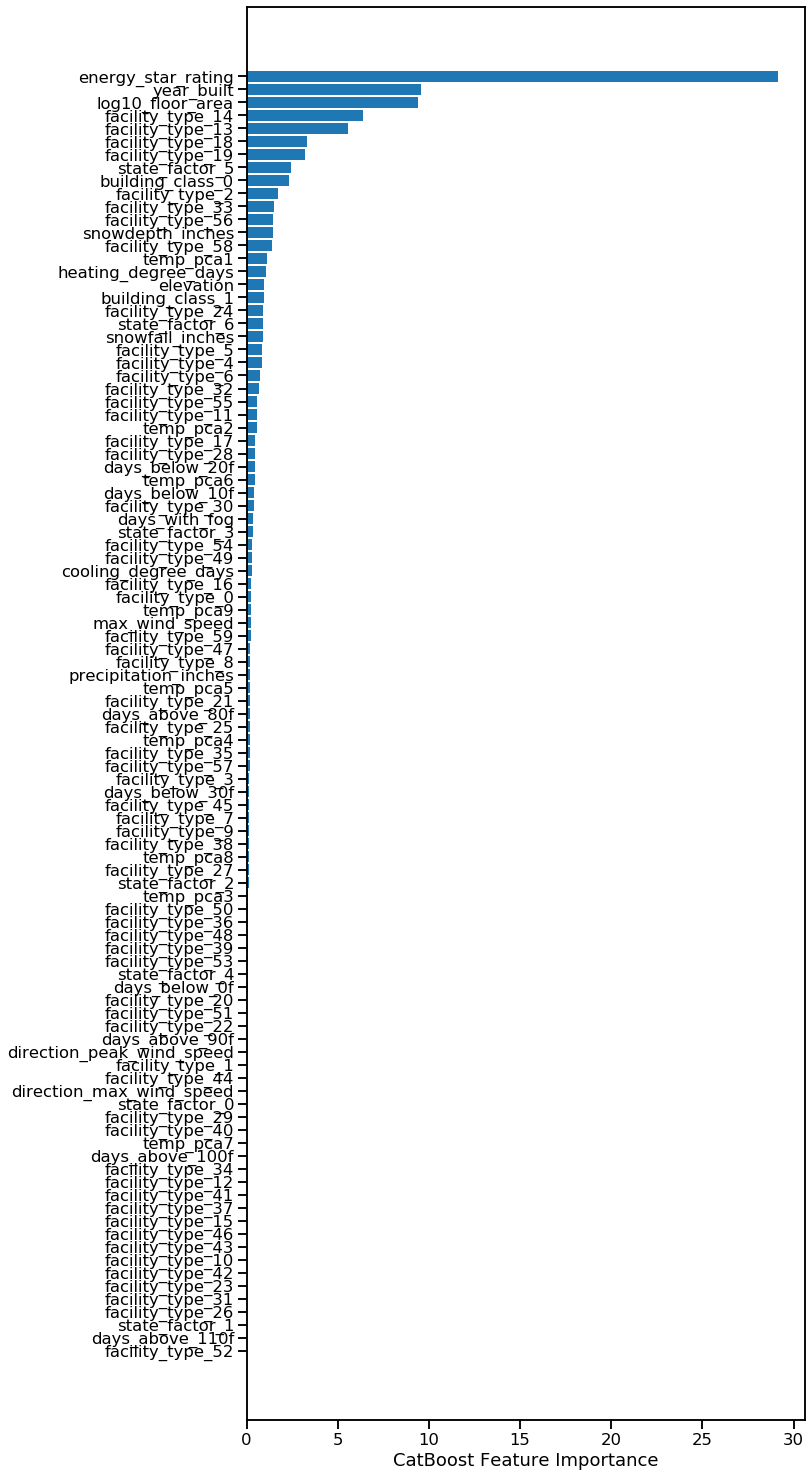

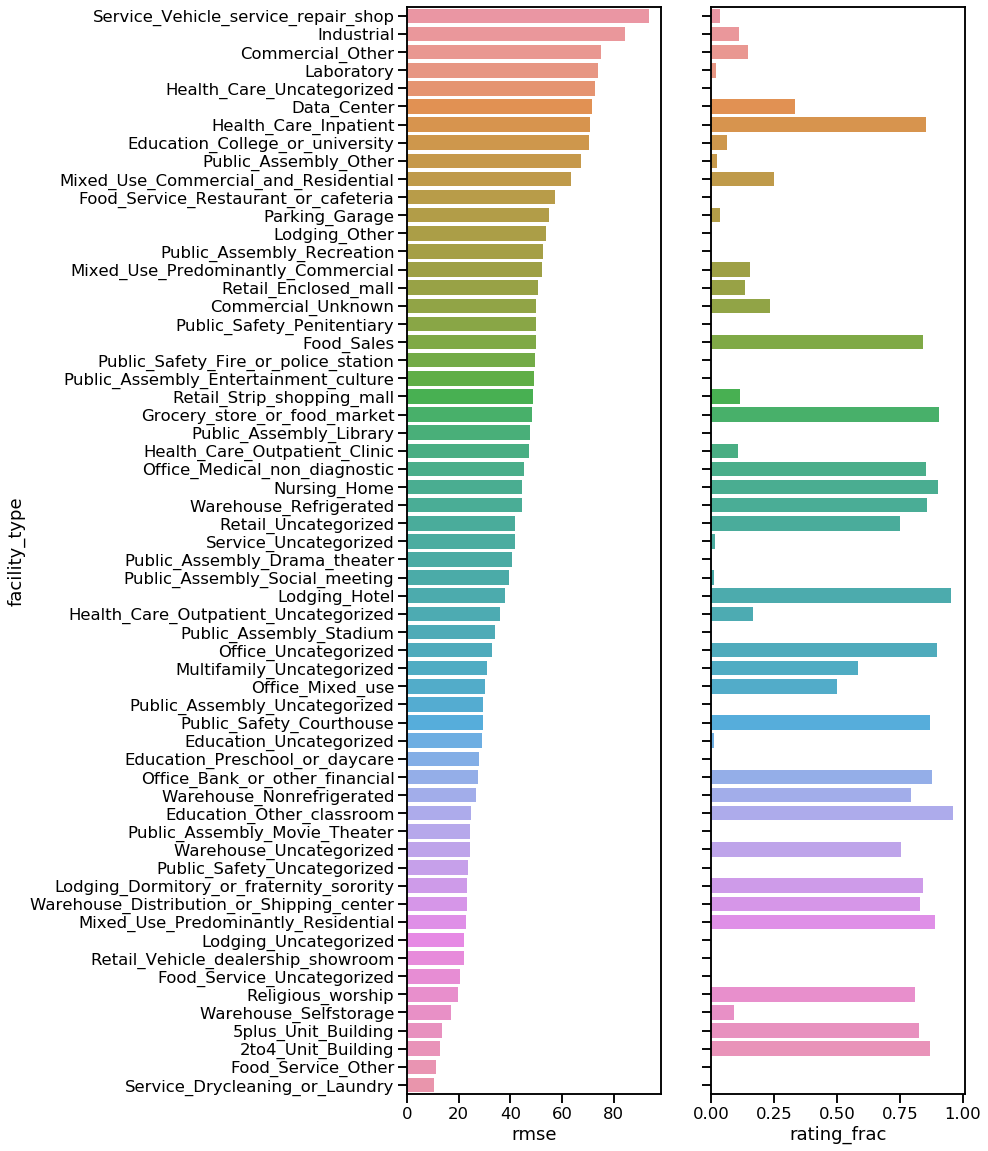

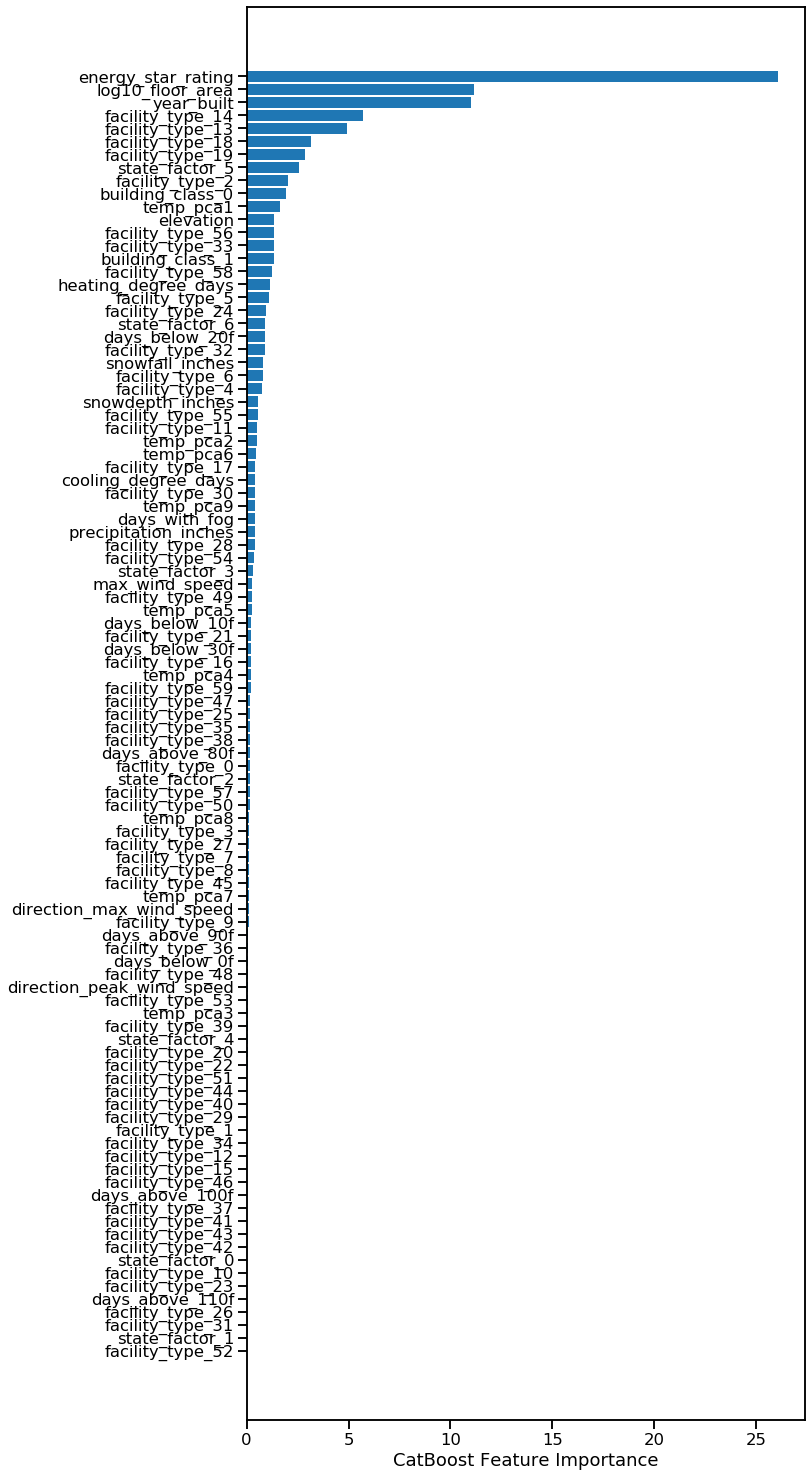

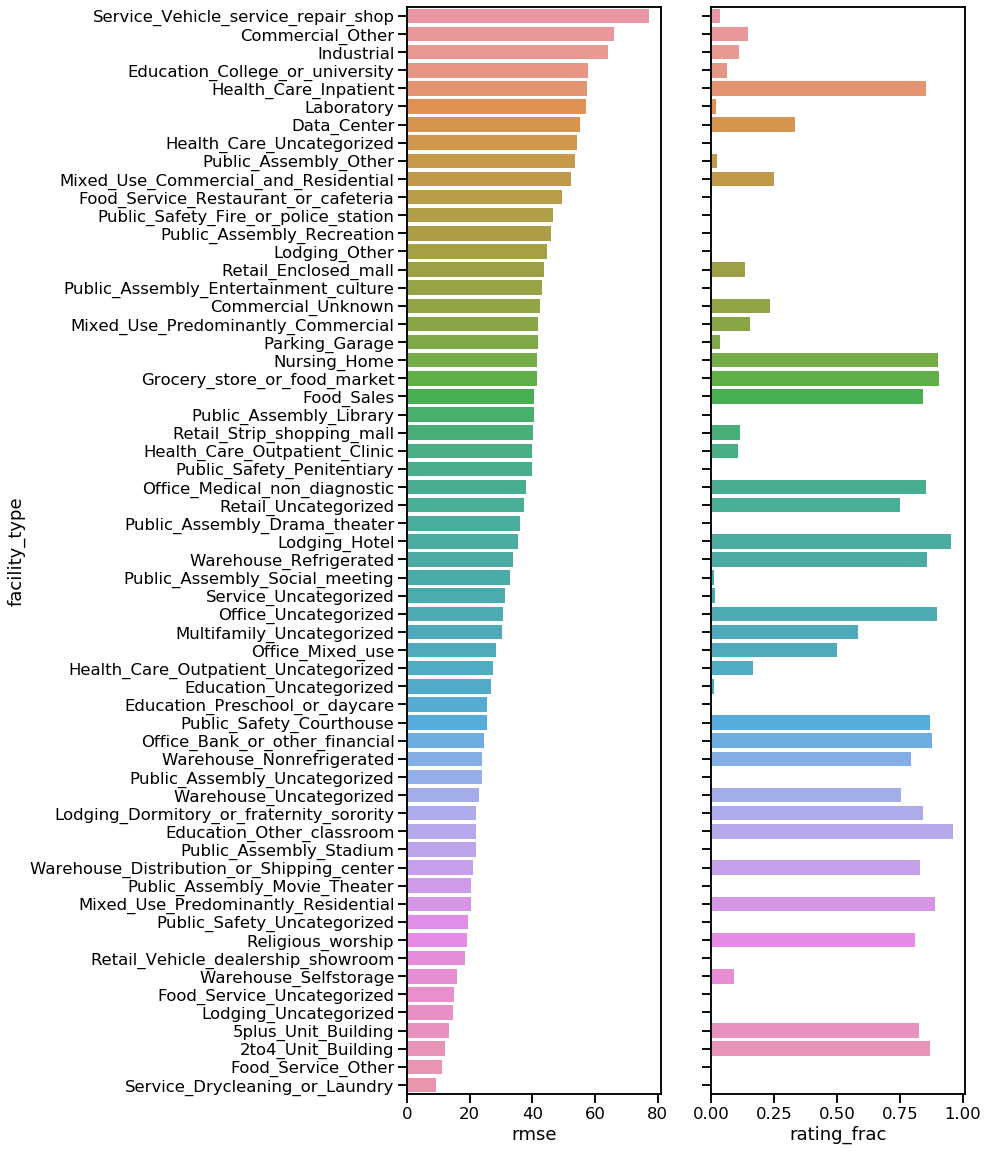

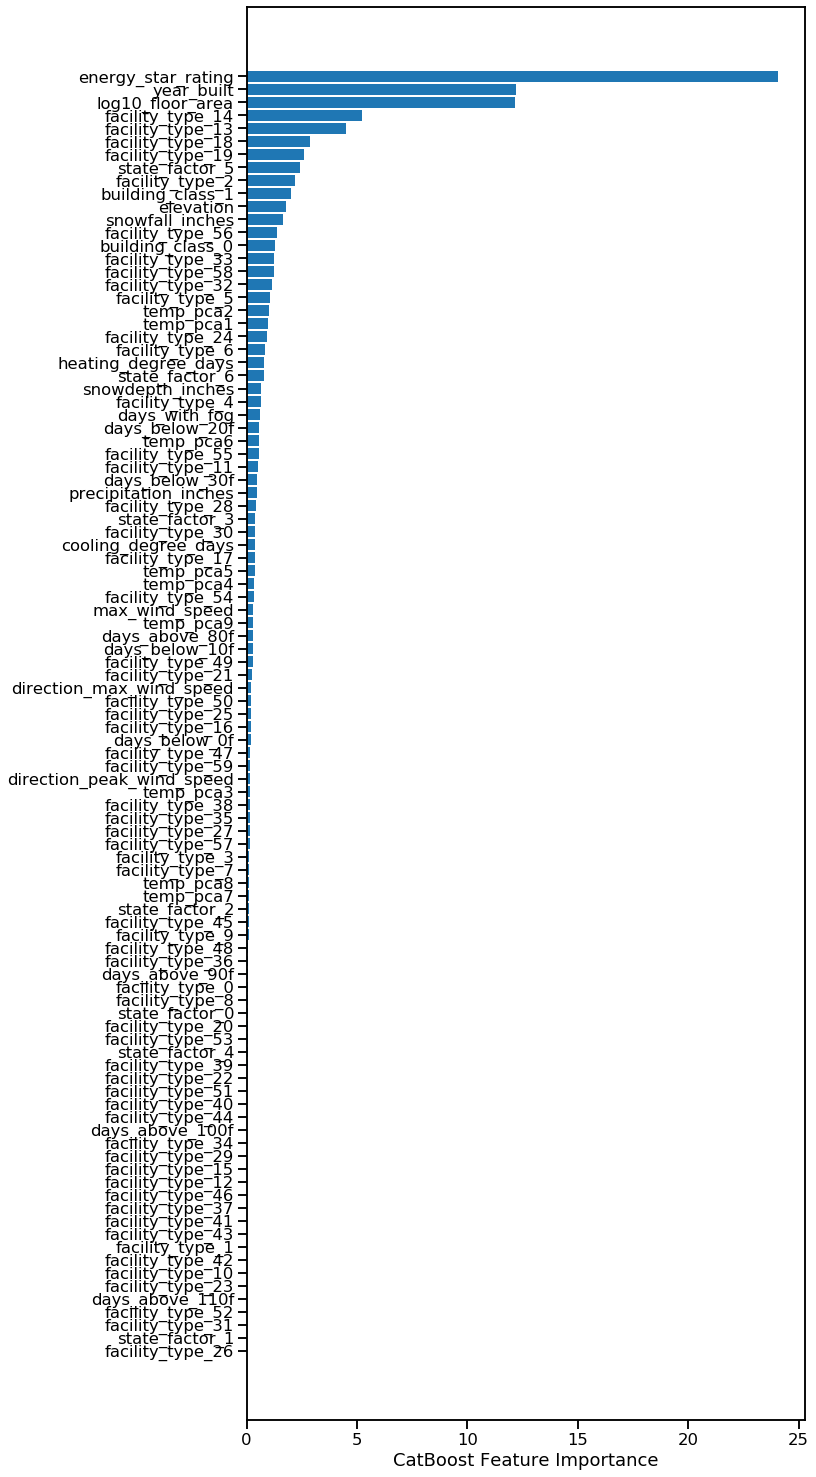

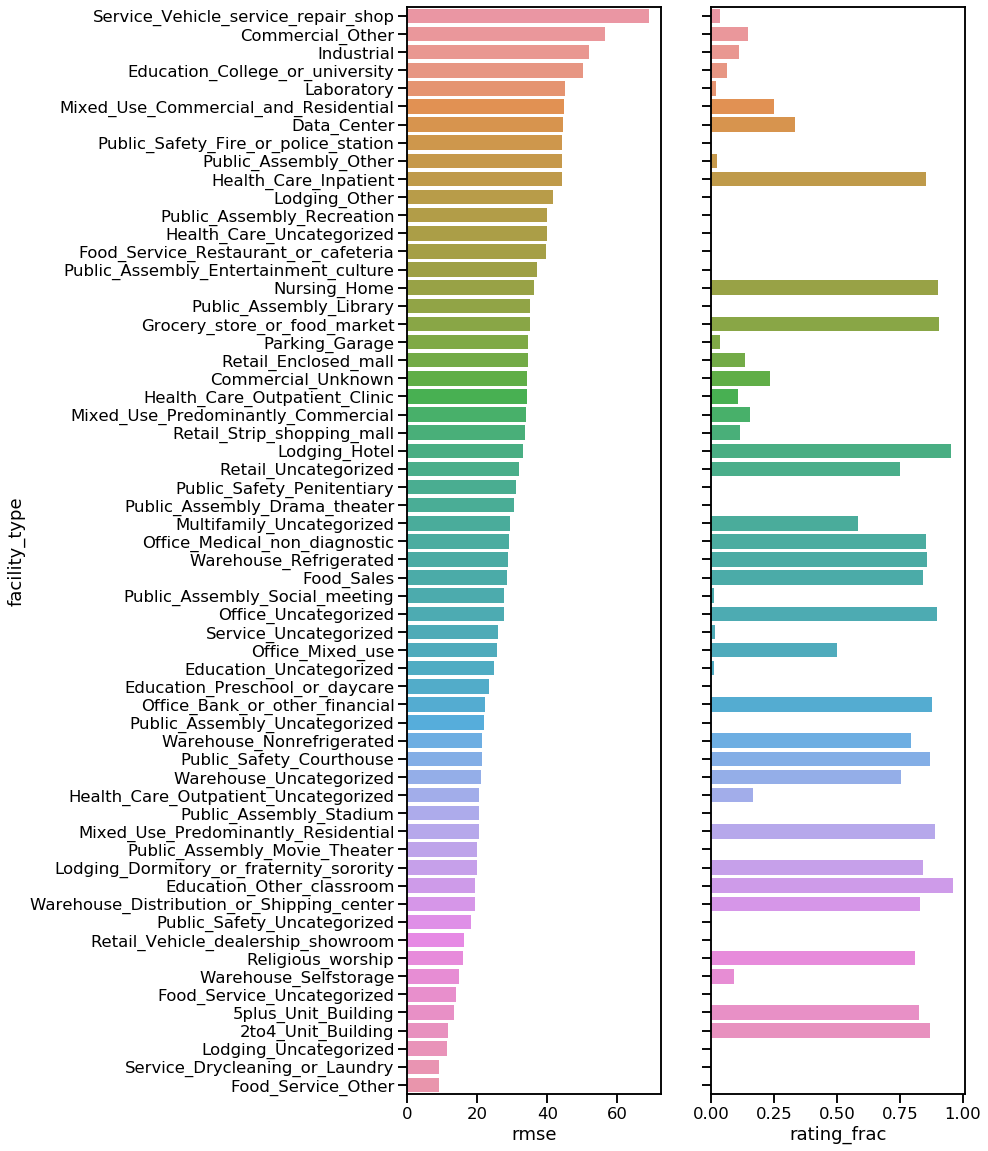

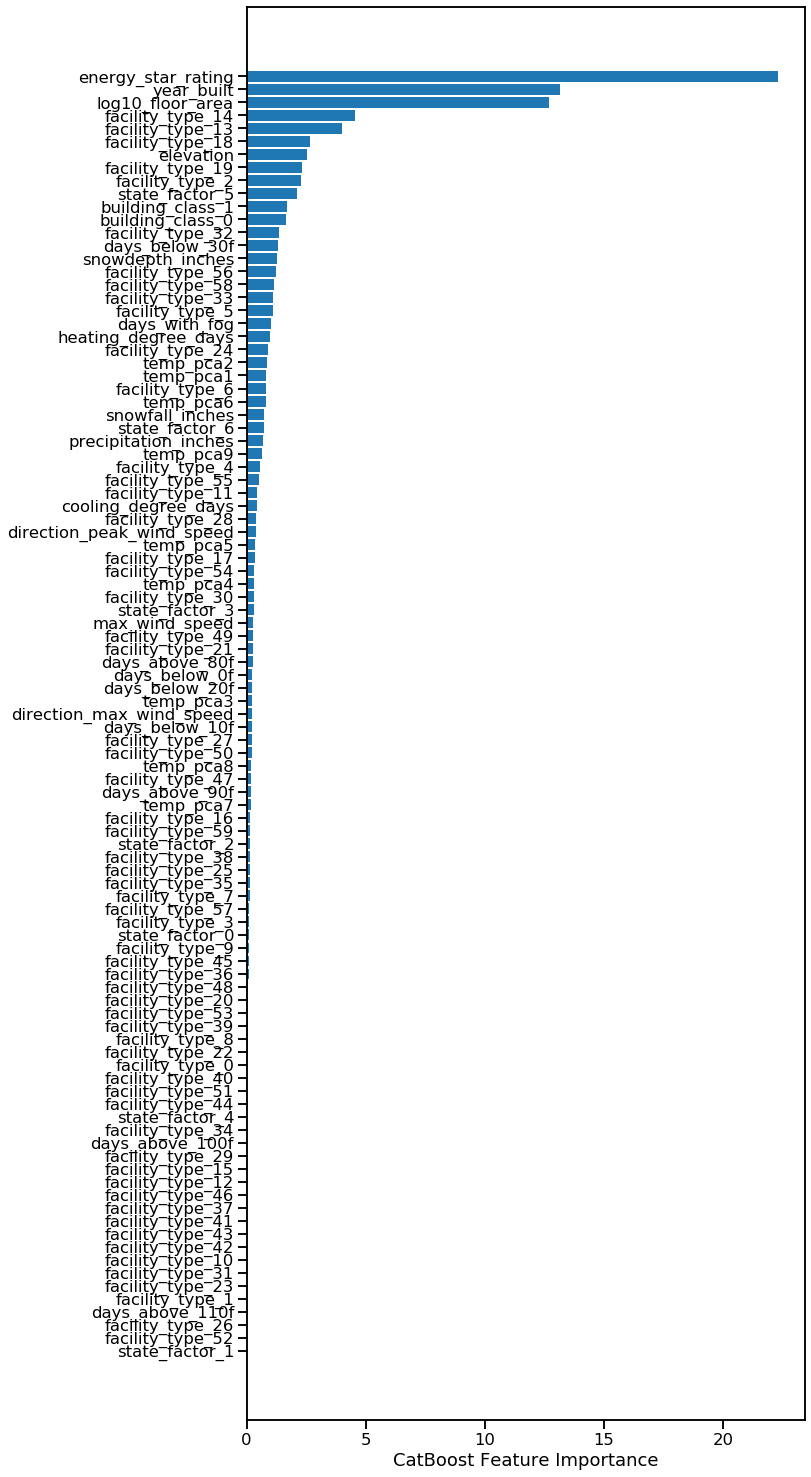

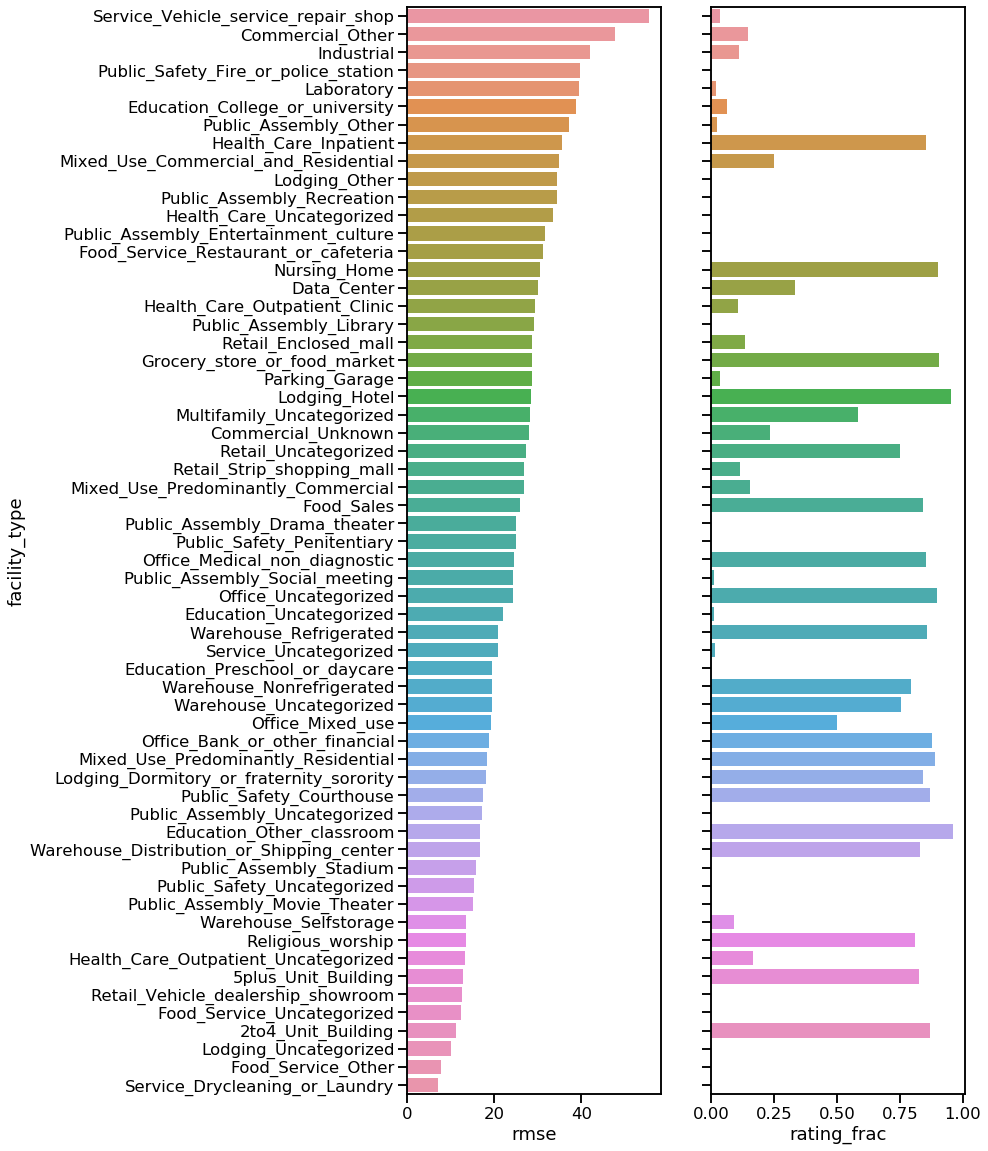

<IPython.core.display.Javascript object>

In [8]:
for depth in [6, 8, 10, 12]:  # PCA on all of the environmental factor cols!
    model = cb.CatBoostRegressor(loss_function="RMSE", depth=depth, verbose=False)

    ## Run LOY model
    catboost_rmse = mu.run_leave_year_out(
        model_df=train_filter_df,
        ml_model=model,
        features_columns=features_columns,
        if_scale_data=if_scale,
        if_one_hot=if_one_hot,
        model_type="catboost",
    )
    print(f"Average RMSE:\n{catboost_rmse.mean()}")
    display(catboost_rmse)

    ## predict on test data
    train_filter_x_df, train_filter_y_df = mu.split_model_feature_response(
        train_filter_df, features_columns
    )
    test_filter_x_df = mu.split_model_feature_response(
        test_filter_df, features_columns, if_with_response=False
    )
    processed_train_x_df, processed_test_x_df = mu.process_train_test_data(
        train_filter_x_df, test_filter_x_df, if_scale, if_one_hot,
    )

    train_predict, test_predict = mu.run_catboost_model(
        model, processed_train_x_df, train_filter_y_df, processed_test_x_df
    )
    training_rmse = mu.calculate_rmse(train_filter_y_df, train_predict)
    print(f"Whole data train RMSE: {training_rmse}")

    ## output save result
    catboost_rmse.loc[catboost_rmse.shape[0], :] = [0, training_rmse, np.nan]
    catboost_rmse["method"] = catboost_rmse["left_out_year"].apply(
        lambda x: "loyo" if x > 0 else "whole train"
    )
    display(catboost_rmse)
    catboost_rmse.to_csv(
        f"{wids_path}/validation_result/{config_name}_depth{depth}.csv", index=False
    )

    test_prediction_result = test_df[["id"]]
    test_prediction_result["site_eui"] = test_predict
    test_prediction_result.to_csv(
        f"{wids_path}/prediction_result/{config_name}_depth{depth}.csv", index=False
    )

    plot_catboost_feature_importance(model)
    plt.savefig(
        f"{wids_path}/validation_result/{config_name}_feature_importance_depth{depth}.png"
    )

    rmse_df = get_rmse_by_group(
        train_filter_x_df.rename(
            columns={"backfilled_energy_star_rating": "energy_star_rating"}
        ),
        train_filter_y_df,
        train_predict,
    )
    plot_rmse_by_group(rmse_df)
    plt.savefig(
        f"{wids_path}/validation_result/{config_name}_rmse_by_group_depth{depth}.png"
    )

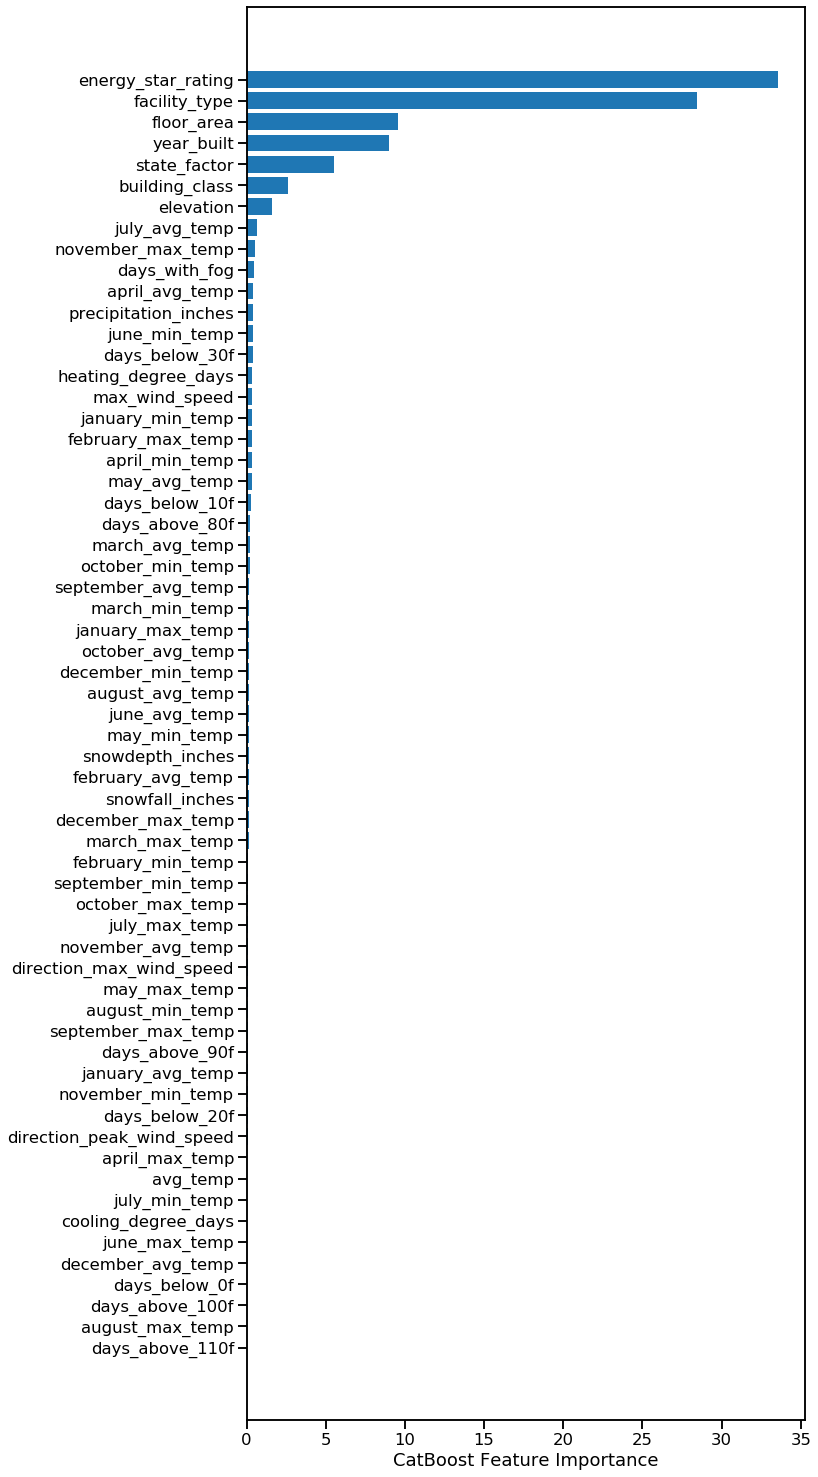

<IPython.core.display.Javascript object>

In [10]:
# fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
# sns.barplot(data=pd.melt(catboost_rmse, id_vars=['left_out_year', 'method']),
#                  x='left_out_year', y='value', hue='variable', ax = axes[0])
# axes[0].legend([])
# sns.barplot(data=pd.melt(catboost_rmse, id_vars=['left_out_year', 'method']),
#             x='method', y='value', hue='variable', ax=axes[1])
# axes[1].legend(bbox_to_anchor=(1,1))
# plt.savefig(f"{wids_path}/validation_result/{config_name}_rmse_summary.png")

<IPython.core.display.Javascript object>

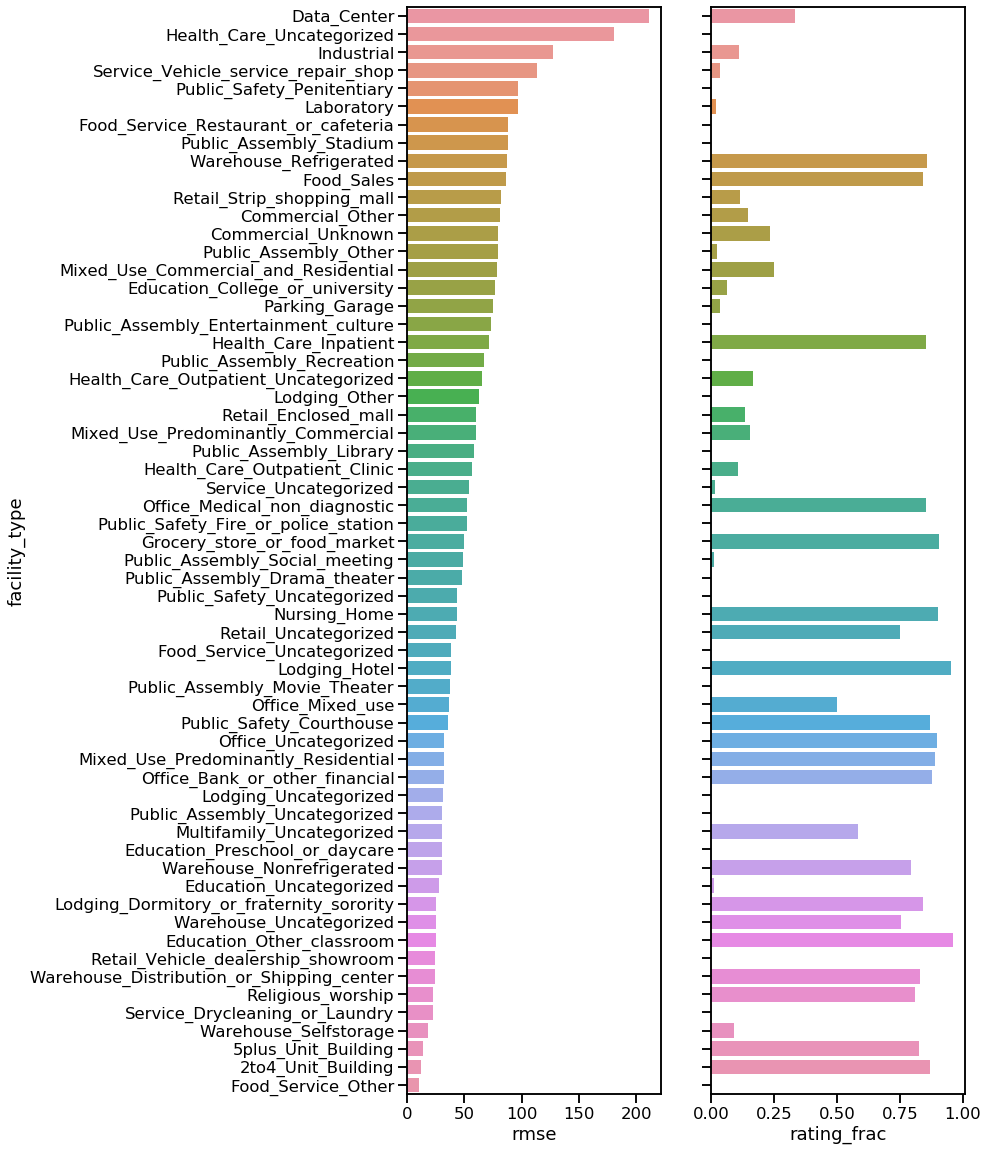

<IPython.core.display.Javascript object>

# Dev cells below this point

In [13]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0

<IPython.core.display.Javascript object>

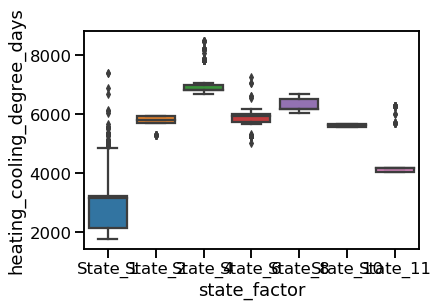

In [14]:
train_filter_df['heating_cooling_degree_days'] = train_filter_df['heating_degree_days'] + train_filter_df['cooling_degree_days']
sns.boxplot(data=train_filter_df, x='state_factor', y='heating_cooling_degree_days')

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:1213: UserWarning: No contour levels were found within the data range.
  **contour_kws,


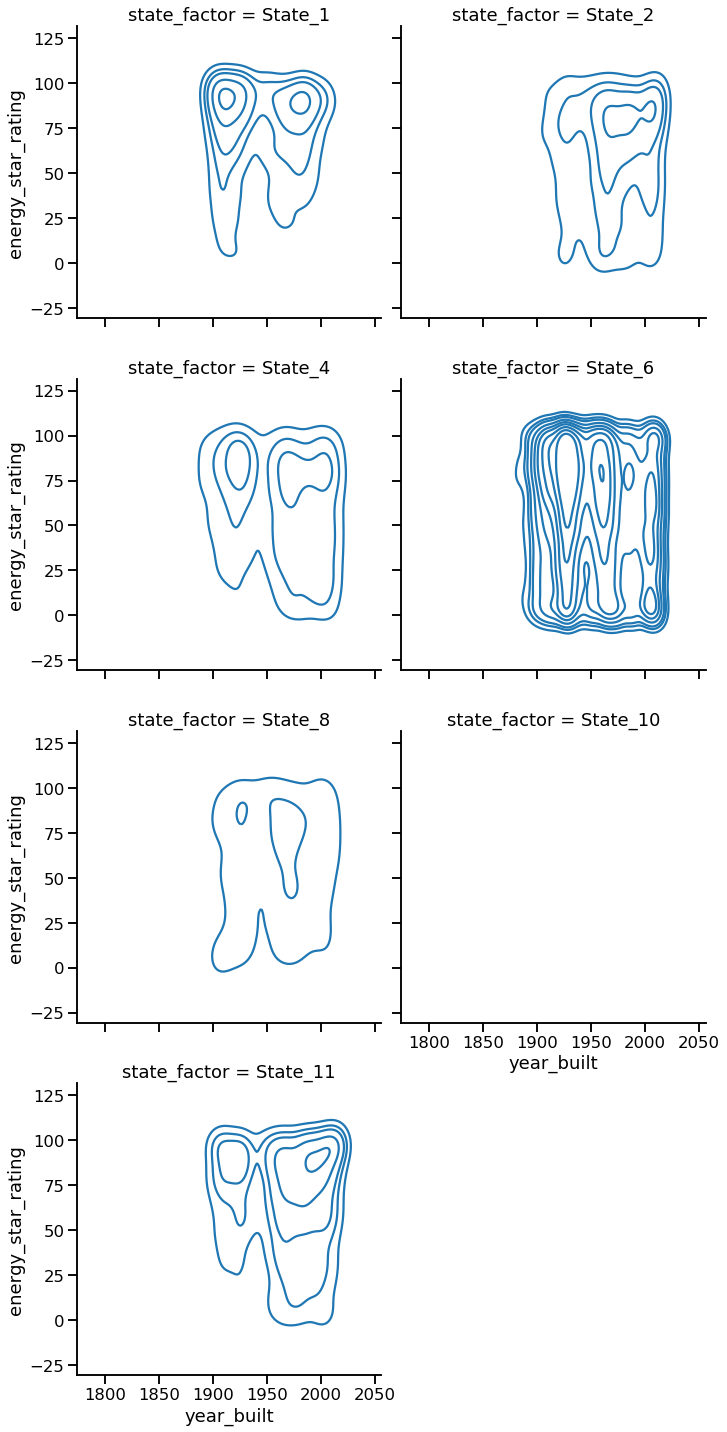

In [40]:
sns.displot(data=train_df.query("year_built>1800"), x='year_built', y='energy_star_rating', col='state_factor',
            col_wrap=2, kind='kde')

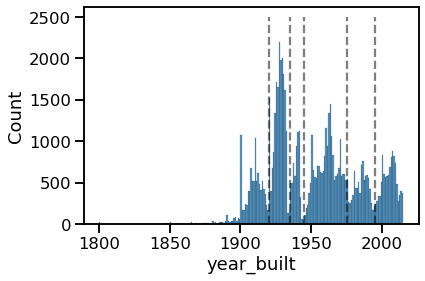

In [31]:
ax = sns.histplot(train_filter_df['year_built'], binwidth=1)
year_built_bins = [1800, 1920, 1935, 1945, 1975, 1995, 2022]
ax.vlines(year_built_bins, ymin=0, ymax=2500, linestyles='--', alpha=0.5)

# norm = plt.Normalize(train_filter_df['site_eui'].min(), train_filter_df['site_eui'].max())
# sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
# sm.set_array([])

# # Remove the legend and add a colorbar
# ax.get_legend().remove()
# ax.figure.colorbar(sm)

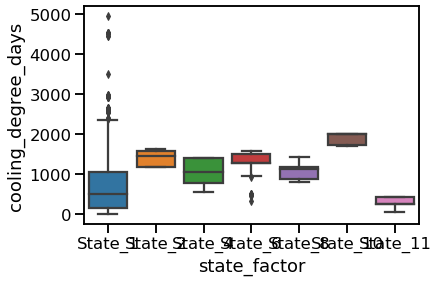

In [12]:
sns.boxplot(data=train_filter_df, x='state_factor', y='cooling_degree_days')

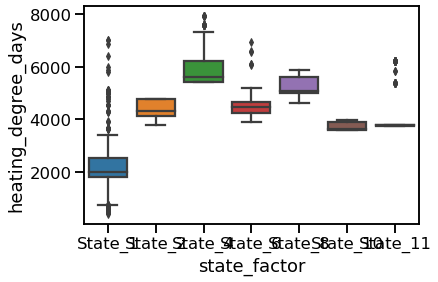

In [13]:
sns.boxplot(data=train_filter_df, x='state_factor', y='heating_degree_days')

In [7]:
merged_train_df = combine_features_and_prediction(train_filter_x_df, train_filter_y_df, train_predict)

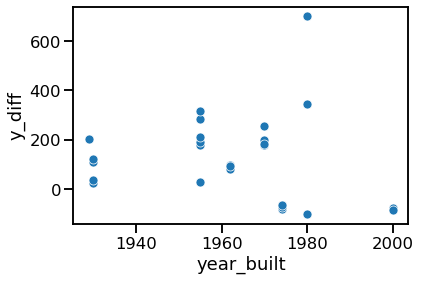

In [16]:
sns.scatterplot(data=merged_train_df.query("facility_type == 'Data_Center'"), x='year_built', y='y_diff')

In [20]:
merged_train_df.query("facility_type == 'Data_Center'")

,days_with_fog,max_wind_speed,year_built,energy_star_rating,direction_max_wind_speed,facility_type,direction_peak_wind_speed,state_factor,elevation,building_class,temp_pca1,temp_pca2,temp_pca3,temp_pca4,temp_pca5,temp_pca6,temp_pca7,temp_pca8,temp_pca9,temp_pca10,temp_pca11,log10_floor_area,y_true,y_pred,y_diff
13,NaN,1.0,1955.0,13.0,1.0,Data_Center,1.0,State_1,2.4,Commercial,9.899709,-3.664954,-2.872117,3.225393,-0.140553,-3.029312,0.462378,0.819529,-1.101217,-0.359836,0.923391,5.790140,608.839519,431.258818,177.580701
930,88.0,1.0,1955.0,14.0,1.0,Data_Center,1.0,State_1,2.4,Commercial,7.518657,3.457206,3.574886,3.848093,1.827769,-0.530686,-0.918268,-0.422340,-0.550403,-1.628838,-0.638583,5.790140,616.121303,425.027204,191.094098
1291,NaN,NaN,1955.0,19.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,7.106097,3.361153,3.129690,3.997770,2.140610,1.388952,-0.196029,-0.454147,-0.178477,-1.323137,-0.558002,5.790140,656.063562,445.931537,210.132024
2505,NaN,NaN,1955.0,24.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,10.970392,3.047361,-1.925137,3.131750,-0.112876,-2.462378,-0.800062,-1.030637,-0.534855,1.775066,1.415461,5.790140,752.066575,468.463168,283.603407
3599,NaN,NaN,1955.0,20.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,8.413486,8.410656,4.567929,2.726743,3.824258,0.029617,2.210053,0.568842,-2.781827,-2.069750,-1.260825,5.790140,775.608943,459.798062,315.810881
4195,NaN,NaN,2000.0,NaN,NaN,Data_Center,NaN,State_1,9.1,Commercial,8.413486,8.410656,4.567929,2.726743,3.824258,0.029617,2.210053,0.568842,-2.781827,-2.069750,-1.260825,5.279190,40.395053,114.603068,-74.208015
4640,NaN,NaN,1955.0,1.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,11.556235,-1.967200,-3.681439,3.868389,-0.633642,-3.298225,0.471599,-1.728747,0.185836,1.482774,0.220019,5.790140,524.064208,496.449437,27.614771
5239,NaN,NaN,2000.0,NaN,NaN,Data_Center,NaN,State_1,45.7,Commercial,11.556235,-1.967200,-3.681439,3.868389,-0.633642,-3.298225,0.471599,-1.728747,0.185836,1.482774,0.220019,5.279190,38.594262,121.418366,-82.824104
14842,12.0,1.0,1980.0,99.0,1.0,Data_Center,1.0,State_6,3.4,Commercial,-0.906130,1.185162,-0.191659,-1.535895,-0.678208,1.663895,0.557920,-1.453838,1.681902,-2.113088,0.466441,4.820077,502.542373,157.706680,344.835693
26916,93.0,1.0,1974.0,39.0,1.0,Data_Center,1.0,State_6,25.6,Commercial,-0.353112,0.033485,0.063749,-1.833425,2.561516,-1.113903,-1.056279,0.582233,0.647049,0.624359,-0.541793,6.040877,54.182890,118.480214,-64.297324
